To open notebook in Colab please click below:
<a href="https://colab.research.google.com/github/bwolfson2/data_biz_2021/blob/main/Module_2_Supervised_Learning/2%20Supervised%20segmentation.ipynb" target="_parent"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" /> </a>'

In [1]:
#If opening in colab run this cell
#!git clone https://github.com/bwolfson2/foster_2021
#%cd foster_2021/Module2_Supervised/

# Linear Models


Summer 2021 - Instructors: Roger M. Stein and Ben Wolfson

Teaching Assistant: Ben Wolfson

***

## Set-up and housekeeping

### Some general imports

In [2]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')

## Define some helper functions that we will use later

### Performance measure utilities

#### Accuracy

In [4]:
def cm2accuracy(tab):                    # convert 2x2 confusion matrix to accuracy (pct correct)
    correct  = (tab[0][0] + tab[1][1])
    total    = sum(sum(tab))
    accuracy = correct/total
    return(accuracy)

### Visualization

In [1]:
def bool2txt(x,text):
    if x==0 : 
        return text[0]
    else: 
        return text[1]

In [3]:
import copy as c
def Decision_Surface(data, col1, col2, target, orig_model, probabilities=False):
    # Get bounds
    x_min, x_max = data[col1].min(), data[col1].max()
    y_min, y_max = data[col2].min(), data[col2].max()

    # ipdb.set_trace()  # insert this line into any Python code for debugging.  'n' in the dialog box moves to the next line of code
    
    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max,0.5))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    # Get predictions for the mesh
    tdf = data[[col1, col2]]
    # make a copy of the model so we don't corrupt the original
    model = c.deepcopy(orig_model)
    model.fit(tdf, target)
    if probabilities:
        Z = model.predict_proba(meshed_data)[:, 1].reshape(xx.shape)
    else:
        Z = model.predict(meshed_data).reshape(xx.shape)  
        
    # Chart details
    plt.figure(figsize=[12,7])
    plt.title("Decision surface")    
    plt.xlabel(col1)
    plt.ylabel(col2)
    if probabilities:
        # Color-scale on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm_r, alpha=0.4)
    else:
        # Only a curve/line on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, levels=[-1,0,1], cmap=plt.cm.coolwarm_r, alpha=0.4)
    # Plot scatter plot    
    cmap = {1: 'blue', 0: 'red'}
    colors = [cmap[c] for c in df[target_col]]
    plt.scatter(data[col1], data[col2], color=colors)
    # Build legend
    plt.legend(handles=[mpatches.Patch(color=cmap[k], label=k) for k in cmap], loc="best", title="target", frameon=True)
    plt.show() 
    

## Doing some data science: Predicting who will survive the Titanic

This time we will use a clasic introductory dataset that contains demographic and traveling information for the Titanic passengers. The goal is to predict the survival of these passengers. We will only keep a few variables of interest and transform all of them to numeric variables. We will also drop some outliers.

In [42]:
# Load data
# path = "./data/titanic.csv"
path="./data/"
fn = "titanic.csv"
full_path= path+fn
df = pd.read_csv(full_path)[["survived", "pclass", "sex", "age", "fare","onboard_spend"]].dropna()

### Familiarizing ourselves with the data

In [43]:
# Take a look at the data
# --> Always look at your data before you start anylizing it!

df.head()

,survived,pclass,sex,age,fare,onboard_spend
0,1,1,female,29.0000,211.3375,92.712680
1,1,1,male,0.9167,151.5500,89.008734
2,0,1,female,2.0000,151.5500,183.286621
3,0,1,male,30.0000,151.5500,209.652730
4,0,1,female,25.0000,151.5500,232.656395


In [44]:
# Take a look at how it is distributed
# --> Always look at the distributions of your data before you start anylizing it!

summary_quantiles = [0.01,0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

print(df.columns)
df.describe(percentiles=summary_quantiles).T

# Transposing the data frame (df.T or df.Transpose())is a good habit for at least two reasons:
#  1) It is cognitively easier to compare columnwise than rowwise
#  2) If you have a lot of variables, it is easier to scroll down to see them rather than to have them scroll off the screen.

Index(['survived', 'pclass', 'sex', 'age', 'fare', 'onboard_spend'], dtype='object')


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
survived,1045.0,0.408612,0.491813,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000
pclass,1045.0,2.206699,0.841542,1.0000,1.000000,1.000000,1.000000,1.00000,2.000000,3.000000,3.000000,3.000000,3.000000,3.00000
age,1045.0,29.851834,14.389201,0.1667,0.916700,5.000000,14.000000,21.00000,28.000000,39.000000,50.000000,56.800000,65.000000,80.00000
fare,1045.0,36.686080,55.732533,0.0000,5.544500,7.229200,7.750000,8.05000,15.750000,35.500000,82.045800,136.550020,262.375000,512.32920
onboard_spend,1045.0,54.762492,65.757584,0.0000,0.320943,2.440324,4.487234,10.54171,32.309928,79.228585,117.973578,158.506098,330.046082,549.65813


At first this seemed to work, but if we look closely, we see that one column is missing (`sex`).  If we want to see that variable, we will need to transform it into a numeric value.

In [45]:
# Transform sex column to a numeric variable
df["female"] = (df.sex == "female").astype(int)
df = df.drop("sex", axis="columns")

# Drop outliers. This is to help the visualization in the next examples.
# --> In general, identifying and determining whether / how to deal with outliers is non-trival
df = df[df.fare < 400]

# Take a look at the data
df.head(10)

,survived,pclass,age,fare,onboard_spend,female
0,1,1,29.0000,211.3375,92.712680,1
1,1,1,0.9167,151.5500,89.008734,0
2,0,1,2.0000,151.5500,183.286621,1
3,0,1,30.0000,151.5500,209.652730,0
4,0,1,25.0000,151.5500,232.656395,1
5,1,1,48.0000,26.5500,46.146006,0
6,1,1,63.0000,77.9583,175.032310,1
7,0,1,39.0000,0.0000,0.000000,0
8,1,1,53.0000,51.4792,135.820925,1
9,0,1,71.0000,49.5042,48.534051,0


###  Exploratory Data Analysis (EDA)

We'd like to use information about the passengers to predict whether they will survive. Let's start by taking a look at how well some of the variables "split" the data according to our target.

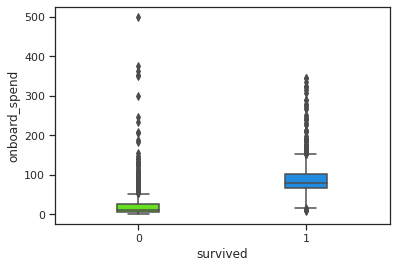

In [48]:
bp=sns.boxplot(x="survived", y="onboard_spend", width=0.25, linewidth=1.5, data=df,palette="gist_rainbow")



Above we see boxplots that shows the fare distribution grouped by our target variable (survival). The left boxplot corresponds to people that died and the right one to people that survived. Alternatively, we could plot the distribution of fare according to survival:

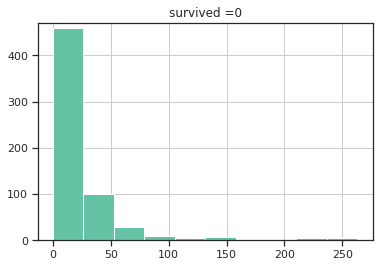

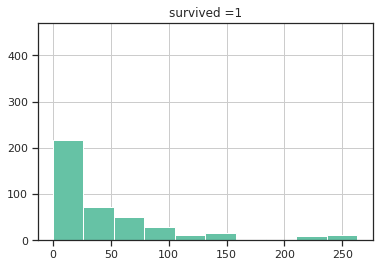

In [34]:
for r in range(2):
    hist = df[df.survived == r].hist('fare')
    plt.title("survived =" + str(r))
    plt.ylim(0,470)
    plt.show()

It seems that people that paid less are less likely to survive. We could use this to predict that people that paid more than 50 will survive. How effective is this threshold? Let's quantify it!

### More EDA

Other observed features may also give us a strong clue about survival.  We could try to get a sense by slicing and plotting the data in a number of ways: 

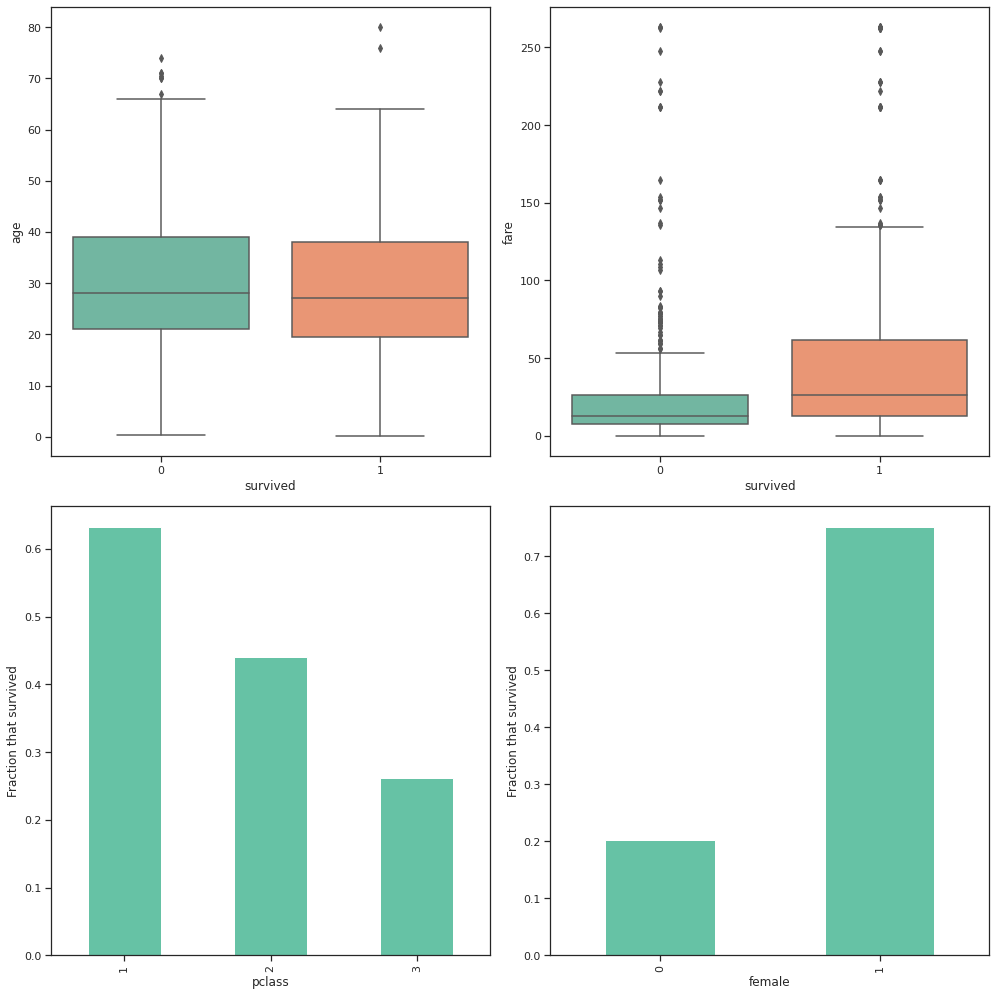

In [35]:
# Names of different columns
categorical_cols = ["pclass", "female"]
continuous_cols = ["age", "fare"]
target_col = "survived"
predictor_cols = categorical_cols + continuous_cols

# This is to plot everything in a 2x2 space
rows, cols = 2, 2
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(7*cols, 7*rows))
axs = axs.flatten()
posn = 0

# Plot continous features
for col in continuous_cols:
    sns.boxplot(x=target_col, y=col, data=df, ax=axs[posn])
    axs[posn].set_ylabel(col)
    axs[posn].set_title("")
    posn += 1

# Plot categorical features
for col in categorical_cols:
    df.groupby(col)[target_col].mean().plot(kind="bar", ax=axs[posn])
    axs[posn].set_ylabel("Fraction that survived")
    posn += 1
    
plt.tight_layout()

Note the graphs, as we've drawn them here, are a little misleading.  If we're not careful, we might conlcude, by looking at the bottom row, that passengers identifying as female, regardless of passenger class, survived at about the same rate as did first class passengers, regardless of gender.  But this is not the case. The reason that we are tempted to conclude this is that the bars are visually similar in height.  However, this only happened because we did not force the y-axes of the two bottom figures to have the same scale.  

Even if we fixed this, it might *still* be misleading.  (Why?)

To get another perspective, we could try to up our visualization game by putting more information into a single plot.  For example, we can combine the information on passenger outcomes by gender *and* fare in a single visualization.  (We will have to do a little extra work to make it look nice...)  

Let's try that in two different ways:

In [15]:
# Prep to do some cosmetic work based on data

surv_labels = ["died","survived"]
gend_labels = ["male","female"]

surv=[]
gend=[]
for i in df.index:
    x=bool2txt(df.loc[i].at["survived"],surv_labels)
    surv.append(x)
    x=bool2txt(df.loc[i].at["female"],gend_labels)
    gend.append(x)

df["surv_txt"] = surv
df["gend_txt"] = gend

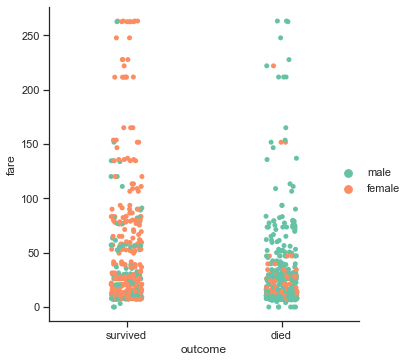

In [16]:
# Plot the data one way...

p1=sns.catplot(x="surv_txt", y="fare", data=df,hue="female")

# Do some more cosmetic work to make plot more cognitively pleasing

p1.set_xlabels("outcome")

for t, l in zip(p1._legend.texts, gend_labels): t.set_text(l)
p1._legend.set_title("")
plt.show()

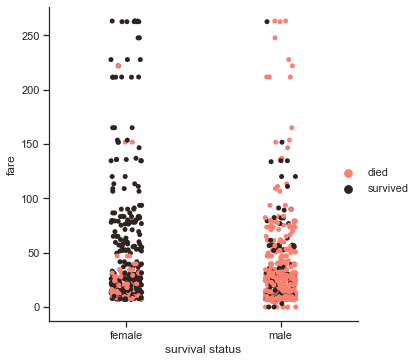

In [17]:
# Plot the data another way...

p2=sns.catplot(x="gend_txt", y="fare", data=df,hue="survived",palette="dark:salmon_r")

# Do some more cosmetic work to make plot more cognitively pleasing

p2.set_xlabels("survival status")

for t, l in zip(p2._legend.texts,surv_labels): t.set_text(l)
p2._legend.set_title("")
plt.show()


# --> It is often the case that packages that make some things really easy require a lot of
#     extra steps if you want to tweak something that is not baked in...

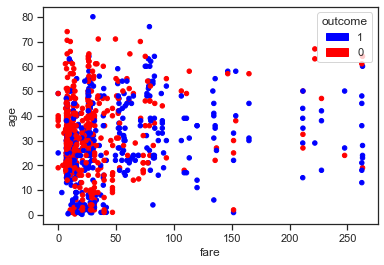

In [18]:
import matplotlib.patches as mpatches

cmap = {1: 'blue', 0: 'red'}
df.plot(kind="scatter", x="fare", y="age", c=[cmap[c] for c in df[target_col]])
plt.legend(handles=[mpatches.Patch(color=cmap[k], label=k) for k in cmap], loc=1, title="outcome", frameon=True)
plt.show()

This now begs the question: which features provide the most information? 

### The Logit model: Parametric Probability Estimation

We will start our modeling, as we often do, with "traditional" statistical techniques.  For many problems, conventional statistical or econometric methods are sufficient, or better, than many ML methods, and are often much easier to interpret.

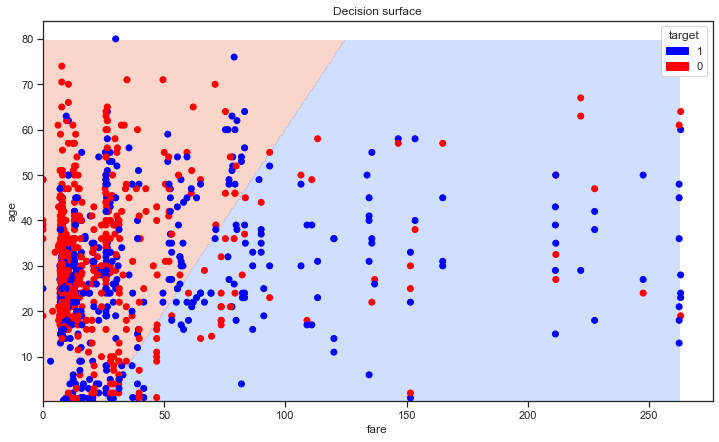

In [19]:
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')

logit_model = linear_model.LogisticRegression()
logit_model.fit(X=df[predictor_cols], y=df[target_col])
Decision_Surface(df, "fare", "age", df.survived, logit_model, False)

And now, using `statsmodels`:

In [20]:
# set up the formula.  
#   This is a general code snippet that will always work, even if we don't know the formula
#   In this case, of course, I do know the formua and could just write: survived ~ pclass + female + age + fare
#

my_formula=target_col + ' ~ '
for i in range(len(predictor_cols)):
    if i > 0:
        my_formula = my_formula + " + "       
    my_formula = my_formula+ predictor_cols[i]
print("Formula: ", my_formula)

Formula:  survived ~ pclass + female + age + fare


In [21]:
import statsmodels.formula.api as smf

# We could use this:
#
#   df = sm.add_constant(df, prepend=False)
#   predictor_cols = 'const' + predictor_cols
#   model = sm.Logit(df[target_col], df[predictor_cols])
#   logit_model_sm = model.fit()
#
# But using formulas is easier...

model = smf.logit(my_formula, data = df) 
logit_model_sm = model.fit()
print(logit_model_sm.summary())



Optimization terminated successfully.
         Current function value: 0.469878
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                 1041
Model:                          Logit   Df Residuals:                     1036
Method:                           MLE   Df Model:                            4
Date:                Thu, 08 Jul 2021   Pseudo R-squ.:                  0.3044
Time:                        15:32:06   Log-Likelihood:                -489.14
converged:                       True   LL-Null:                       -703.19
Covariance Type:            nonrobust   LLR p-value:                 2.351e-91
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2563      0.445      5.068      0.000       1.384       3.129
pclass        -1.1830      0.

Note how useful the `statsmodels` output is for gaining insights into the processes that drive the probability of `survival` in the data set.

For example, we can see that all of the variables, except for `fare`, appear to be significant at conventional levels.  

However, the coefficients of a logit are difficult to interpret directly in the same way we interpret the coefficients for a model estimatd useing OLS (because of the non-linear link function).

Fortunately, `statsmodles` also lets us calculate the marginal effects to see the "average" effect of each factor.

In [22]:
mfx = logit_model_sm.get_margeff()
print(mfx.summary())

        Logit Marginal Effects       
Dep. Variable:               survived
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pclass        -0.1793      0.018     -9.792      0.000      -0.215      -0.143
female         0.3821      0.013     29.066      0.000       0.356       0.408
age           -0.0052      0.001     -5.659      0.000      -0.007      -0.003
fare          -0.0003      0.000     -0.867      0.386      -0.001       0.000


Interesting!  

It looks like on "average,"  a passenger who was `female` would have had a 38% higher chance of survival than one who was `male`. 

How does that overall result compare to how `female` Third Class passengers did releative to `male` Third Class passengers?

In [23]:
pclass_col = 1                      # in which column is the passenger class data located?
is_first_class = {pclass_col: 1}    # map to records of First Class passengers

mfx = logit_model_sm.get_margeff(atexog=is_first_class)
print(mfx.summary())

        Logit Marginal Effects       
Dep. Variable:               survived
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pclass        -0.2082      0.019    -11.182      0.000      -0.245      -0.172
female         0.4437      0.025     17.870      0.000       0.395       0.492
age           -0.0060      0.001     -6.100      0.000      -0.008      -0.004
fare          -0.0003      0.000     -0.875      0.382      -0.001       0.000


It looks like `female` passengers in First Class did even better.  

In fact, in First Class, `female` passengers were about 6% *more* likely to survive (`0.4437` - `0.3821`).  This may be due to the shortage of lifeboats, which were first allocated to the First Class passengers, forcing many lower class passengers into the icy water.

(How big an effect on survival did `pclass` have for `female` passengers?)


#### Evaluating the results (a little ...)

We also compute accuracy metrics (for either `scikitlearn` models or `statsmodels` models),  in a number of ways.  

For this example, we are going to calculate a very coarse measure of performance: *the percentage of correct classifications*.  Later in the course, we will look at more robust and informative measures of performance.

In [24]:
# Calculate accuracy using of sklearn logit model using sklearn's metrics package

from sklearn import metrics
pd.DataFrame([dict(zip(predictor_cols, logit_model.coef_[1:]))])
pred = logit_model.predict(df[predictor_cols])
pred_bin    = np.where(pred > 0.5, True, False)  # sk.metrics needs discrete valued data
sk_logit_accuracy = metrics.accuracy_score(pred_bin, df[target_col])   

# Calculate accuracy of statsmodels logit model sklearn's metrics package

pred        = logit_model_sm.predict(df)
pred_bin    = np.where(pred > 0.5, True, False)  # sk.metrics needs discrete valued data
sm_logit_skm_accuracy = metrics.accuracy_score(pred_bin, df.survived)

# Calculate accuracy of statsmodels logit model using statsmodels pred.table (confusion matrix)

logit_pred_tab = logit_model_sm.pred_table()
sm_logit_sm_accuracy = cm2accuracy(logit_pred_tab)



print("Confusion Matrix")

print(pd.DataFrame(logit_pred_tab))
print()

# Compare results

print ("Accuracy (sk logit) fr SKM = %.2f" % sk_logit_accuracy)
print ("Accuracy (sm logit) fr CM  = %.2f" % sm_logit_skm_accuracy)
print ("Accuracy (sm logit) fr SKM = %.2f" % sm_logit_skm_accuracy)



Confusion Matrix
       0      1
0  525.0   93.0
1  125.0  298.0

Accuracy (sk logit) fr SKM = 0.79
Accuracy (sm logit) fr CM  = 0.79
Accuracy (sm logit) fr SKM = 0.79


# Polynomial Regression and Other Transformations

## Motivational example

Imagine we have some noisy observations from a nonlinear function. We're going to approximate that function by fitting a polynomial to the observations. 

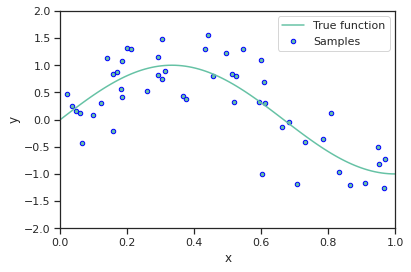

In [72]:
num_samples = 50
# Set randomness so that we all get the same answer
np.random.seed(42)

def true_function(X):
    return np.sin(1.5 * np.pi * X)

def plot_example(X, Y, functions,xmax=1,xlim=(0, 1),ylim=(-2, 2)):
    # Get some X's to plot the functions
    X_test = pd.DataFrame(np.linspace(0, xmax, 100), columns=['X'])
    # Plot stuff
    for key in functions:
        plt.plot(X_test, functions[key](X_test), label=key)
    plt.scatter(X, Y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(loc="best")

# Add X in the range of [0, 1]
X = pd.DataFrame(np.sort(np.random.rand(num_samples)), columns=['x1'])
# Add some random noise to the observations
Y = true_function(X.x1) + np.random.randn(num_samples) * 0.5
# Plot stuff
functions = {"True function": true_function}
plot_example(X, Y, functions)
plt.show()

Let's assume that we don't know the true function, choosing to model our noisy observations using linear regression.  (Recall that we had a sneak peek at building linear regression models in Python at the end of the Class #1 notebook; compare with the fitting of models for binary target variables from last class.)

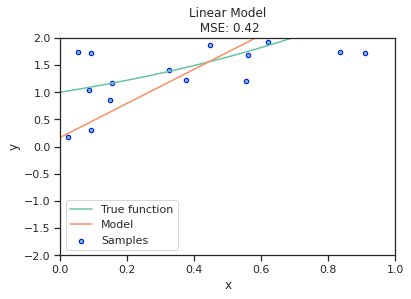

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Fit linear model
model = LinearRegression()
model.fit(X, Y)
# Evaluate model with mean squared error; just as an example
mse = mean_squared_error(Y, model.predict(X))
# Plot results
functions["Model"] = model.predict
plot_example(X, Y, functions)
#Note how you can customize your plots
plt.title("Linear Model\n MSE: %.2f" % mse)
plt.show()

Clearly the linear regression doesn't fit our data super well. Rather than trying a linear regression, let's attempt polynomial regression. How do different degree polynomials fit the data? Recall that a polynomial on a single variable looks like:

$$ a_1 + a_2 x + a_3 x^2 + ... $$

In [6]:
##
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def fit_polynomial(X, Y, degree):
    # create different powers of X
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
    pipeline.fit(X, Y)
    return pipeline

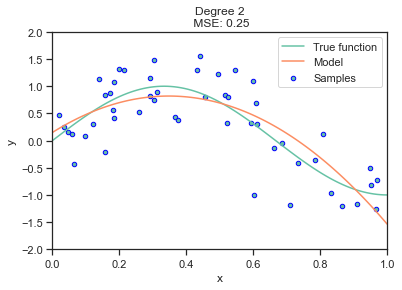

In [7]:
def plot_poly(X, Y, degree):
    # Fit polynomial model
    model = fit_polynomial(X, Y, degree)
    # Evaluate model
    mse = mean_squared_error(Y, model.predict(X))
    # Plot results
    functions["Model"] = model.predict
    plt.title("Degree %d\n MSE: %.2f" % (degree, mse))
    plot_example(X, Y, functions)
    
plot_poly(X, Y, degree=2)
plt.show()

This seems to fit our data better than the purely linear model. What if we use polynomials with higher degrees?

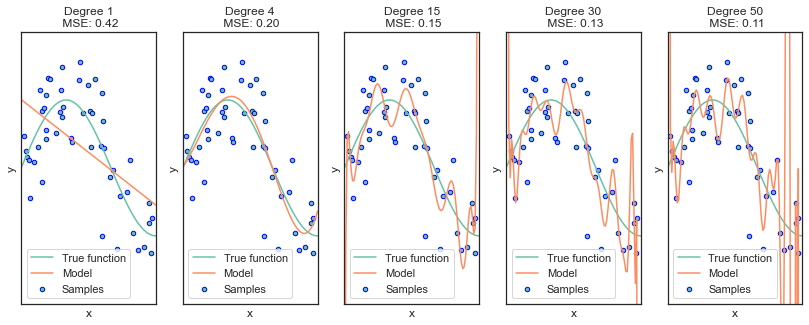

In [8]:
plt.figure(figsize=(14, 5))
# degrees of the polynomial
degrees = [1, 4, 15, 30, 50]
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())
    plot_poly(X, Y, degrees[i])
plt.show()

## Log Transforms

Often there are other functional transformations that may improve the fit of your regressions.

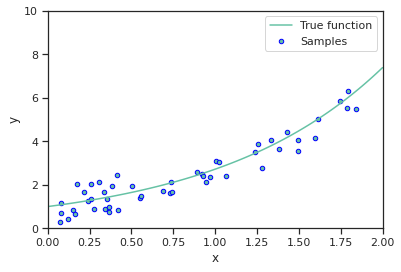

In [96]:
# Add X in the range of [0, 1]

def true_function(X):
    return np.exp(X)

X = pd.DataFrame(2*np.sort(np.random.rand(num_samples)), columns=['x1'])
# Add some random noise to the observations
Y = true_function(X.x1) + np.random.randn(num_samples) * 0.5
# Plot stuff
functions = {"True function": true_function}
plot_example(X, Y, functions,xmax=2,xlim=(0,2),ylim=(0,10))
plt.show()

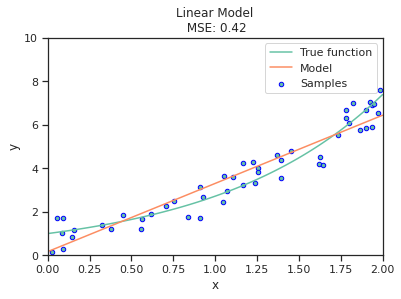

In [95]:
# Fit linear model
def transformed_func(X):
    return np.log(true_function(X))

model = LinearRegression()
model.fit(X, Y)
# Evaluate model with mean squared error; just as an example
mse = mean_squared_error(Y, model.predict(X))
# Plot results
functions["Model"] = model.predict
plot_example(X, Y, functions,xmax=2,xlim=(0,2),ylim=(0,10))
#Note how you can customize your plots
plt.title("Linear Model\n MSE: %.2f" % mse)
plt.show()

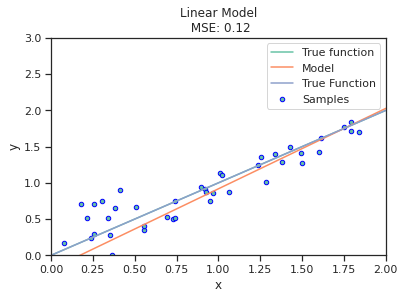

In [100]:
# Fit linear model
transformed_Y = np.log(Y)
model = LinearRegression()
model.fit(X, transformed_Y)
# Evaluate model with mean squared error; just as an example
mse = mean_squared_error(transformed_Y, model.predict(X))
# Plot results
functions["Model"] = model.predict
functions["True function"] = transformed_func
plot_example(X, transformed_Y, functions,xmax=2,xlim=(0,2),ylim=(0,3))
#Note how you can customize your plots
plt.title("Linear Model\n MSE: %.2f" % mse)
plt.show()

## Outlier Detection

Outlier are data points that lie outside of the *regular* distribution data points. The definition of *regular* is based on the context of the data. Many times when fitting a model particularly models that are sensitive to outliers like linear models, it is important to consider the effects of outliers. Treatment of outliers, as with many other things that we have seen, is context dependent. Assume, for instance, that we have 1000's of datapoints of companies that did/did not default and we are trying to predict default. When a company deviates significantly on it's credit rating (which would be considered an outlier), a low rating may indicate default and thus be a very good predictor. Whereas companies that deviate on square foot of office space, may indicate that the companies at hand are too small to be considered by the modeler and should be removed.

Either way, detecting outlier is usually a crucial step in data analysis/model building. We discuss here the simplest method of detecting outliers called bivariate.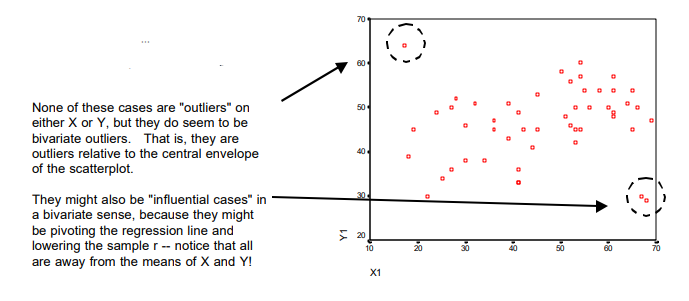 Outliers are bivariate if they deviate along X and Y, when examined relative to other (X,Y) points.

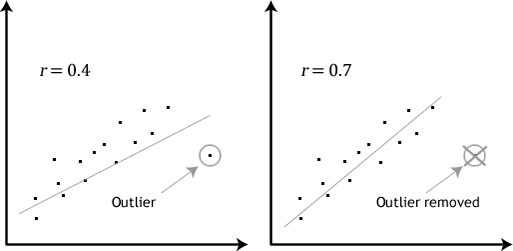

## Resources

Outliers:
https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561

